In [1]:
import numpy as np
import nashpy as nash
import random
import matplotlib.pyplot as plt

In [2]:
'''
The idea is to have players with different speeds, sizes and health attributes play a series of "games",
called a "match". The payoff matrix is decided based on the attributes of the players.
A strategy is basically a probability distribution on the set of possible moves of the player. 
For now I am merely dealing with attacks and dodges, 0 being attacks and 1 being dodges
'''
class Player:
    def __init__(self, speed = random.randint(1,100), size = random.randint(1,100), health = 100, strategy = [0.5, 0.5]):
        self.speed = speed
        self.size = size
        self.health = health
        self.strategy = strategy



In [20]:
class NormalFormGame:
    def __init__(self, player1, player2):
        self.player1_strategy = player1.strategy
        self.player2_strategy = player2.strategy
        self.player1 = player1
        self.player2 = player2

        self.payoff_matrix = np.array([[[0,0], [0,0]],
                                       [[0,0], [0,0]]])
        
        # payoff computation statistics
        self.environment_harshness = random.random()/4 # to compute the damage on dodging due to environmental factors
        self.retaliation_stat = (player1.size + player2.size)/200 # consider this elasticity parameter, which decides the damage in case of mutual attacks 
        

    # generates a payoff matrix for a game, using the attributes of the players
    def generatePayoffMatrix(self):
        '''
        my original idea is to use the speed and size parameters to get the payoffs based on attack and dodge combinations
        For attack, attack, the person with larger size wins, and his opponent gets damaged, based on the difference in their size stats. The attacker also gets slightly damaged(recoil). The loser, bears the full brunt of the attack or 0.75 whichever is higher
        For attack, dodge, if the dodger has a higher speed, then the dodger will successfully dodge (small damage based on the dodge speed) and the attacker will get damaged. Otherwise the dodger will get damaged with the difference of "momentum" (a slightly higher penalty)
        For dodge, dodge, there is again, a small penalty, based on their dodge speed
        For dodge, attack we can symmetrically generate the payoffs
        '''
        
        p1_dodge_damage = (self.player1.size*self.player1.speed*self.environment_harshness)/100
        p2_dodge_damage = (self.player2.size*self.player2.speed*self.environment_harshness)/100

        # for attack, attack
        if(self.player1.size > self.player2.size):
            self.payoff_matrix[0,0,0] = -(100*self.retaliation_stat)/(self.player1.size - self.player2.size)
            self.payoff_matrix[0,0,1] = -(self.player1.size - self.player2.size)*max(0.75, self.retaliation_stat) 
        elif(self.player2.size > self.player1.size):
            self.payoff_matrix[0,0,0] = -(self.player2.size - self.player1.size)*max(0.75, self.retaliation_stat) 
            self.payoff_matrix[0,0,1] = -(100*self.retaliation_stat)/(self.player2.size - self.player1.size)
        else:
            self.payoff_matrix[0,0,0] = -100*self.retaliation_stat
            self.payoff_matrix[0,0,1] = -100*self.retaliation_stat

        # for attack, dodge - player 1 attack, player 2 dodge
        if(self.player1.speed > self.player2.speed):
            self.payoff_matrix[0,1,0] = -(100*self.retaliation_stat)/self.player1.size
            self.payoff_matrix[0,1,1] = -(self.player1.size)*max(0.75, self.retaliation_stat) - p2_dodge_damage
        elif(self.player2.speed > self.player1.speed):
            self.payoff_matrix[0,1,0] = -p1_dodge_damage*3
            self.payoff_matrix[0,1,1] = -p2_dodge_damage
        else:
            self.payoff_matrix[0,1,0] = -(100*self.retaliation_stat)/self.player1.size
            self.payoff_matrix[0,1,1] = -(self.player1.size)*max(0.75, self.retaliation_stat)*random.random() - p2_dodge_damage

        # for dodge, attack - player 1 dodge, player 2 attack
        if(self.player1.speed > self.player2.speed):
            self.payoff_matrix[1,0,0] = -p1_dodge_damage
            self.payoff_matrix[1,0,1] = -p2_dodge_damage*3
        elif(self.player2.speed > self.player1.speed):
            self.payoff_matrix[1,0,0] = -(self.player2.size)*max(0.75, self.retaliation_stat) - p1_dodge_damage
            self.payoff_matrix[1,0,1] = -(100*self.retaliation_stat)/self.player2.size
        else:
            self.payoff_matrix[1,0,0] = -(self.player2.size)*max(0.75, self.retaliation_stat)*random.random() - p1_dodge_damage
            self.payoff_matrix[1,0,1] = -(100*self.retaliation_stat)/self.player2.size
        
        # for dodge, dodge
        self.payoff_matrix[1,1,0] = -p1_dodge_damage
        self.payoff_matrix[1,1,1] = -p2_dodge_damage
        

    # Uses the distribution to determine the outcome, can simulate both pure and mixed strategies effectively 
    def simulateGame(self):
        # gets the strategy of the player, 
        index1 = random.choices(range(len(self.player1_strategy)), self.player1_strategy)[0]
        index2 = random.choices(range(len(self.player2_strategy)), self.player2_strategy)[0]
        
        payoff1 = self.payoff_matrix[index1, index2, 0]
        payoff2 = self.payoff_matrix[index1, index2, 1]

        return np.array([payoff1, payoff2])
    
    # Runs a match between the players, until death (i.e. health = 0)
    def simulateMatch(self):
        p1_health = [self.player1.health]
        p2_health = [self.player2.health]
        tickers = [0]
        ticker = 0
        while(self.player2.health > 0 and self.player1.health > 0):
            payoffs = self.simulateGame()
            self.player1.health += payoffs[0]
            self.player2.health += payoffs[1]
            ticker+=1

            p1_health.append(self.player1.health)
            p2_health.append(self.player2.health)
            tickers.append(ticker)

        plt.plot(tickers, p1_health, label='Player 1 Health')
        plt.plot(tickers, p2_health, label='Player 2 Health')
        plt.xlabel('Tickers')
        plt.ylabel('Health')
        plt.title('Player Health Over Match')
        plt.legend()
        plt.show()

        if(p1_health[-1] <= 0 and p2_health[-1] > 0):
            print("Player 2 wins")
        elif(p1_health[-1] > 0 and p2_health[-1] <= 0):
            print("Player 1 wins")
        else:
            print("It is a tie!")

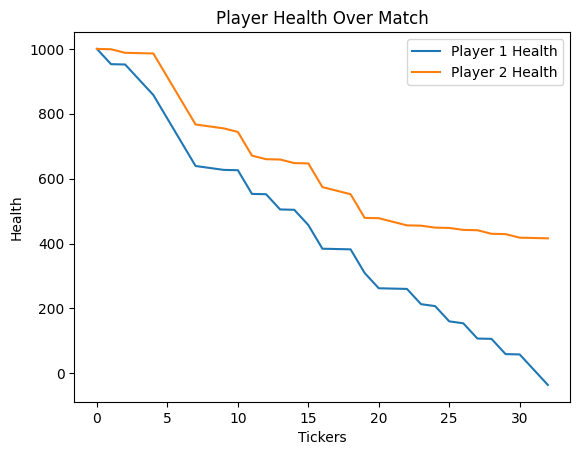

Player 2 wins


In [21]:
player1 = Player(health = 1000)
player2 = Player(health = 1000)

battle = NormalFormGame(player1, player2)
battle.generatePayoffMatrix()
battle.simulateMatch()